<font size="+3"><mark>Interpret the symbolic representations</mark></font>

# Introduction

## README

_Associated GitHub repository: https://github.com/sylvaincom/astride._

## Configuration parameters

In [1]:
IS_SAVE_FIG = True

DATE_EXP = "2023_02_08"

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from sklearn.utils import Bunch
from sklearn.base import clone

from src.metadata import pipe_sax, pipe_astride
from src.utils import create_path, load_ucr_dataset
from src.utils_reconstruction import transform_symb_ts, inv_transform_symb_ts
from src.utils_interpret_symbolization import plot_multivariate_segmentation, plot_symbolization

In [3]:
cwd = Path.cwd()
plt.rcParams['figure.figsize'] = (10, 3)
sns.set_theme()

# Loading the data and preparing the methods

## Loading the input data

In [4]:
b_meat_dataset = load_ucr_dataset("Meat")
b_meat = Bunch(
    dataset_name_ucr="Meat",
    l_train=b_meat_dataset.l_train,
    y_train=b_meat_dataset.y_train,
    n_samples=b_meat_dataset.l_train[0],
    n_segments=4,
    n_symbols=4,
    signal_index=0,
)

In [5]:
b_cbf_dataset = load_ucr_dataset("CBF")
b_cbf = Bunch(
    dataset_name_ucr="CBF",
    l_train=b_cbf_dataset.l_train,
    y_train=b_cbf_dataset.y_train,
    n_samples=b_cbf_dataset.l_train[0],
    n_segments=5,
    n_symbols=4,
    signal_indexes=[2, 6, 14, 27],
)

## Loading the pipeline methods

In [6]:
pipe_sax_meat = clone(pipe_sax)
pipe_sax_cbf = clone(pipe_sax)
pipe_astride_meat = clone(pipe_astride)
pipe_astride_cbf = clone(pipe_astride)

pipe_sax_meat.set_params(
    segmentation__n_segments=b_meat.n_segments,
    symbolization__n_symbols=b_meat.n_symbols,
)
pipe_astride_meat.set_params(
    segmentation__n_segments=b_meat.n_segments,
    symbolization__n_symbols=b_meat.n_symbols,
)
pipe_sax_cbf.set_params(
    segmentation__n_segments=b_cbf.n_segments,
    symbolization__n_symbols=b_cbf.n_symbols,
)
pipe_astride_cbf.set_params(
    segmentation__n_segments=b_cbf.n_segments,
    symbolization__n_symbols=b_cbf.n_symbols,
)

Pipeline(steps=[('timeseriesscalermeanvariance',
                 TimeSeriesScalerMeanVariance()),
                ('segmentation',
                 Segmentation(mean_or_slope='mean', n_segments=5,
                              uniform_or_adaptive='adaptive')),
                ('segmentfeature', SegmentFeature()),
                ('symbolization',
                 Symbolization(lookup_table_type='mof',
                               n_regime_lengths='divide_exact', n_symbols=4,
                               reconstruct_bool=True,
                               symb_quantif_method='quantiles')),
                ('symbolicsignaldistance',
                 SymbolicSignalDistance(distance='lev', n_samples=None)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='precomputed', n_neighbors=1))])

In [7]:
pipe_astride_cbf.get_params()["segmentation__n_segments"]

5

In [8]:
pipe_astride_meat.get_params()["segmentation__n_segments"]

4

## Fitting the pipe and getting our transforms

In [9]:
%%time

pipe_sax_meat.fit(b_meat.l_train, b_meat.y_train)
pipe_astride_meat.fit(b_meat.l_train, b_meat.y_train)
pipe_sax_cbf.fit(b_cbf.l_train, b_cbf.y_train)
pipe_astride_cbf.fit(b_cbf.l_train, b_cbf.y_train)

CPU times: user 592 ms, sys: 23.1 ms, total: 615 ms
Wall time: 791 ms


Pipeline(steps=[('timeseriesscalermeanvariance',
                 TimeSeriesScalerMeanVariance()),
                ('segmentation',
                 Segmentation(mean_or_slope='mean', n_segments=5,
                              uniform_or_adaptive='adaptive')),
                ('segmentfeature', SegmentFeature()),
                ('symbolization',
                 Symbolization(lookup_table_type='mof',
                               n_regime_lengths='divide_exact', n_symbols=4,
                               reconstruct_bool=True,
                               symb_quantif_method='quantiles')),
                ('symbolicsignaldistance',
                 SymbolicSignalDistance(distance='lev', n_samples=None)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='precomputed', n_neighbors=1))])

In [10]:
b_transform_sax_meat = transform_symb_ts(pipe_sax_meat, b_meat.l_train)
b_transform_astride_meat = transform_symb_ts(pipe_astride_meat, b_meat.l_train)
b_transform_sax_cbf = transform_symb_ts(pipe_sax_cbf, b_cbf.l_train)
b_transform_astride_cbf = transform_symb_ts(pipe_astride_cbf, b_cbf.l_train)

In [11]:
l_train_scaled_meat = b_transform_sax_meat.list_of_scaled_signals
l_train_scaled_cbf = b_transform_sax_cbf.list_of_scaled_signals

features_with_symbols_df_sax_meat = b_transform_sax_meat.features_with_symbols_nonumreduc_noquantifseglen_df
features_with_symbols_df_astride_meat = b_transform_astride_meat.features_with_symbols_nonumreduc_noquantifseglen_df
features_with_symbols_df_astride_cbf = b_transform_astride_cbf.features_with_symbols_nonumreduc_noquantifseglen_df

## Get the signal true labels

In [12]:
def assign_true_label(features_with_symbols_df, y_train):
    
    # Get true signal labels (class)
    df_signal_labels = pd.DataFrame(y_train).reset_index().rename(columns={"index":"signal_index", 0:"signal_true_label"})
    df_signal_labels["signal_true_label"] = df_signal_labels["signal_true_label"].astype("int")

    # Assign the true signal label
    features_with_symbols_label_df = features_with_symbols_df.merge(df_signal_labels, on="signal_index", how="left")
    features_with_symbols_label_df.head()

    return features_with_symbols_label_df

In [13]:
features_with_symbols_label_df_sax_meat = assign_true_label(features_with_symbols_df_sax_meat, b_meat.y_train)
features_with_symbols_label_df_astride_meat = assign_true_label(features_with_symbols_df_astride_meat, b_meat.y_train)
features_with_symbols_label_df_astride_cbf = assign_true_label(features_with_symbols_df_astride_cbf, b_cbf.y_train)

# Reconstruction on a single signal

In [14]:
features_with_symbols_label_df = features_with_symbols_label_df_astride_meat.copy()

In [15]:
b_inv_transform_symb_ts = inv_transform_symb_ts(features_with_symbols_label_df)
d_map_symbol_mean = b_inv_transform_symb_ts.d_map_symbol_mean
arr_symb_ts_method_inv = b_inv_transform_symb_ts.arr_symb_ts_method_inv

In [16]:
features_with_symbols_label_df["segment_length"].min()

40

In [17]:
df_map_symbol_mean = (
    pd.DataFrame.from_dict(d_map_symbol_mean, orient="index")
    .reset_index()
    .rename(columns={"index":"segment_symbol", 0:"quantized_mean"})
)
display(df_map_symbol_mean.round(2))

,segment_symbol,quantized_mean
0,0,-1.06
1,1,-0.16
2,2,1.05
3,3,2.38


In [18]:
features_with_symbols_label_df.merge(df_map_symbol_mean, on=["segment_symbol"], how="left").query("signal_index == 0").round(2)

,mean_feat,signal_index,segment_start,segment_end,segment_length,segment_symbol,signal_true_label,quantized_mean
0,-0.17,0,0,266,266,1,1,-0.16
1,1.11,0,266,313,47,2,1,1.05
2,2.34,0,313,353,40,3,1,2.38
3,-1.07,0,353,448,95,0,1,-1.06


*Note*: It corresponds to Table 3 of the paper.

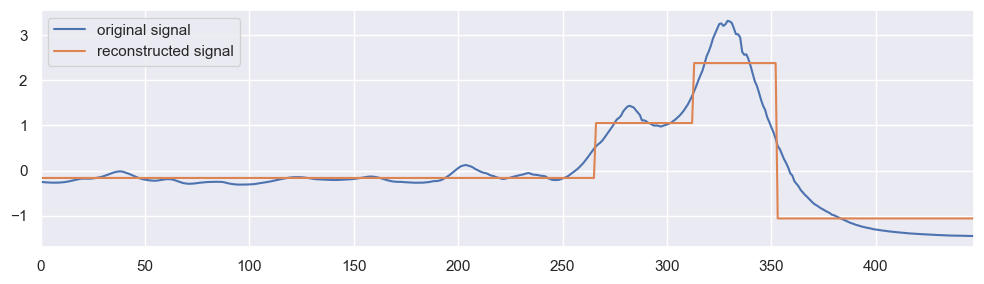

In [19]:
signal_index = b_meat.signal_index

plt.figure(figsize=(10, 3))
plt.plot(l_train_scaled_meat[signal_index], label="original signal")
plt.plot(arr_symb_ts_method_inv[signal_index], label="reconstructed signal")
plt.legend()
plt.tight_layout()
plt.margins(x=0)
if IS_SAVE_FIG:
    folder = cwd / f"results/{DATE_EXP}/img"
    create_path(folder)
    plt.savefig(cwd / f"signal_reconstruction_astride_meat_{signal_index}.png", dpi=200)
plt.show()

*Note*: It corresponds to Figure 4 of the paper.

# Plot the segmentation

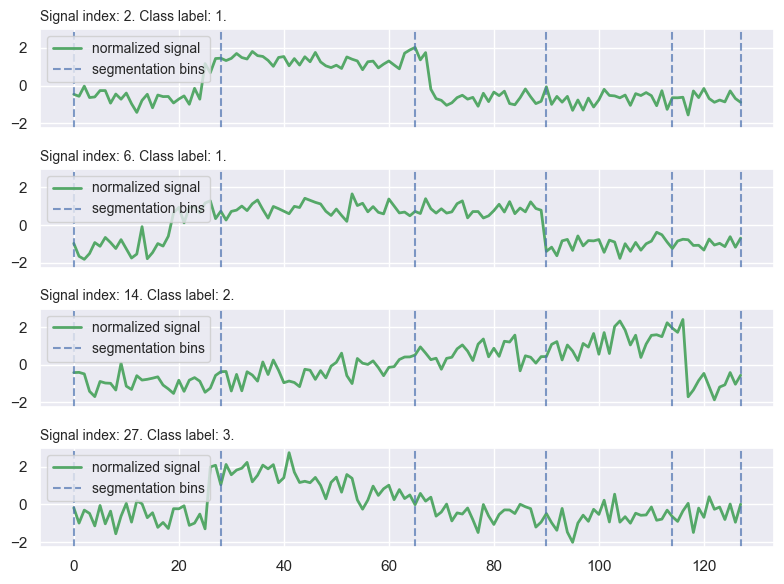

In [20]:
plot_multivariate_segmentation(
    b_dataset=b_cbf,
    b_transform_method_dataset=b_transform_astride_cbf,
    is_save_fig=IS_SAVE_FIG,
    method_name="ASTRIDE",
    date_exp=DATE_EXP,
)

*Note*: It corresponds to Figure 3 of the paper.

# Plot the symbolic representation

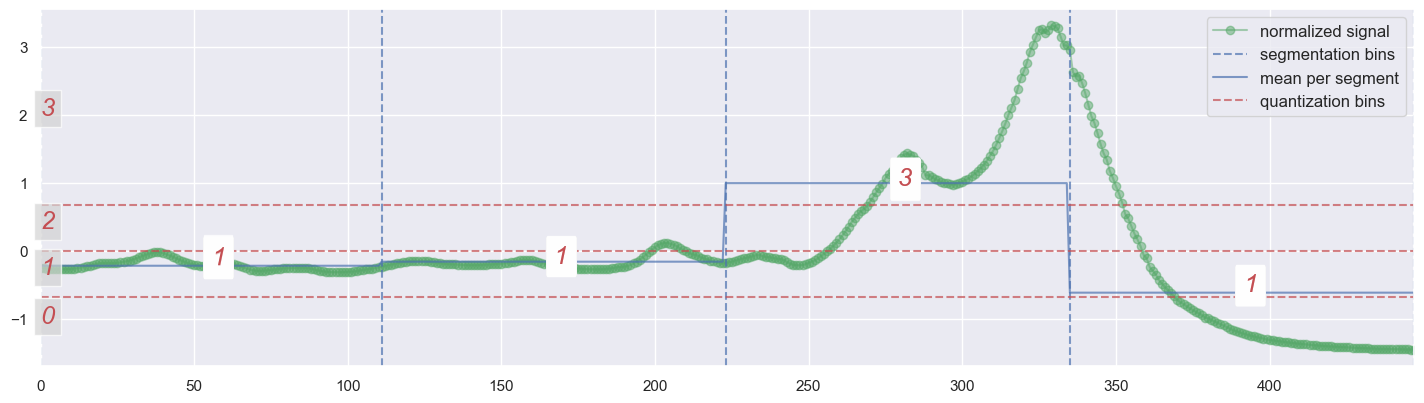

In [21]:
plot_symbolization(
    b_dataset=b_meat,
    b_transform_method_dataset=b_transform_sax_meat,
    features_with_symbols_label_df_method_dataset=features_with_symbols_label_df_sax_meat,
    is_save_fig=IS_SAVE_FIG,
    method_name="SAX",
    date_exp=DATE_EXP,
)

*Note*: It corresponds to Figure 1 of the paper.

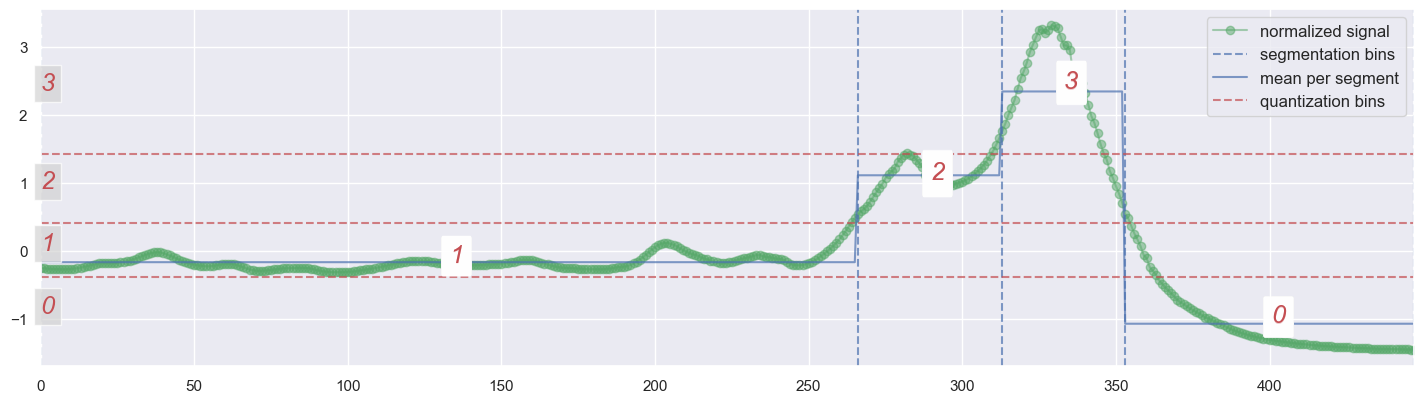

In [22]:
plot_symbolization(
    b_dataset=b_meat,
    b_transform_method_dataset=b_transform_astride_meat,
    features_with_symbols_label_df_method_dataset=features_with_symbols_label_df_astride_meat,
    is_save_fig=IS_SAVE_FIG,
    method_name="ASTRIDE",
    date_exp=DATE_EXP,
)

*Note*: It corresponds to Figure 1 of the paper.